In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold;

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load in train and test datasets
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

#Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x:0 if type(x) == float else 1)

#Feature engineering
#Create new feature FamilySize as a combination of sibsp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone' ] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
for dataset in full_data:
    dataset['Fare']= dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'],4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define the function to extract titles from passengers' names 
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don',
                                                 'Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female':0, 'male':1}).astype(int)
    title_mapping = {"Mr":1 ,"Miss":2, "Mrs":3 ,"Master": 4 ,"Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1 ,'Q':2}).astype(int)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']  = 0
    dataset.loc[ (dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[ (dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ (dataset['Fare'] > 31), 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age' ] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;
    
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)
    

In [4]:
train.head(5)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


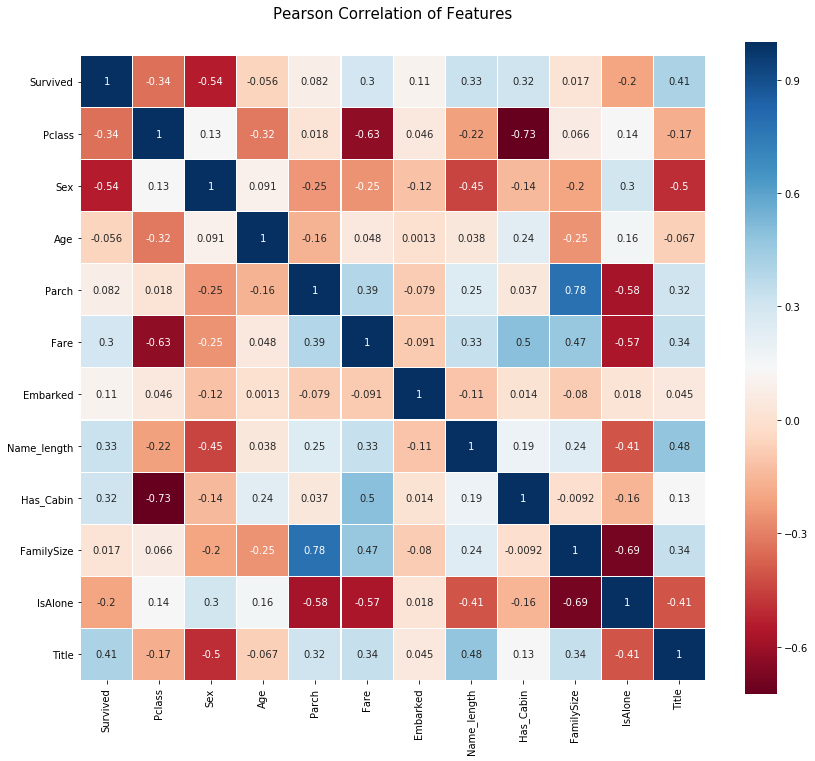

In [5]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [6]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x,y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)


In [7]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, shuffle=False ,random_state=SEED) #K-交叉验证
def get_oof(clf, x_train, y_train, x_test):   #x_train 训练集 y_train 训练集标签 x_test测试集
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i,(train_index, test_index) in enumerate(kf.split(x_train)): #train_index 被分到训练集中的index  同理test_index
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te) # 用验证数据集验证训练集训练好的模型
        oof_test_skf[i, :] = clf.predict(x_test)  # 用测试集测试
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)   

In [8]:
# Put in our parameters for said classifiers
# Forest note:
# the main parameters for these "forest" algorithm is 'n_estimators' and 'max_features'
# Random Forest parameters
rf_params = {
    'n_jobs': -1,                # the number of jobs to run in parallel for both fit and predict
    'n_estimators': 800,         # The number of trees in the forest
     #'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': None,
    'min_samples_leaf': 1,
    'max_features' : 'log2',    # the max number of features to consider when looking for the best split
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':800,
    #'warm_start': True,
    #'max_features': 0.5,
    'max_depth': None,
    'min_samples_leaf': 1,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 600,
    'learning_rate' : 0.05
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 600,
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'verbose': 0
}

In [9]:
# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'sigmoid',
    'C' : 0.025
    }

In [10]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [11]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [12]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [14]:
from sklearn.metrics import accuracy_score
#print(rf_oof_train.reshape(-1))
print(accuracy_score(y_train,rf_oof_train.reshape(-1)))
print(accuracy_score(y_train,et_oof_train.reshape(-1)))
print(accuracy_score(y_train,ada_oof_train.reshape(-1)))
print(accuracy_score(y_train,gb_oof_train.reshape(-1)))
print(accuracy_score(y_train,svc_oof_train.reshape(-1)))

0.812570145903
0.805836139169
0.82379349046
0.800224466891
0.781144781145


In [21]:
#直接使用随机森林
#print(rf_oof_test.round())
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': rf_oof_test.round().reshape(-1).astype(np.int8)})
StackingSubmission.to_csv("RFSubmission.csv", index=False)

In [14]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [15]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 1000,
 max_depth= 5,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [20]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train,gbm.predict(x_train).reshape(-1).tolist()))

0.835016835017


In [18]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("EnsemleSubmission.csv", index=False)